In [1]:
### Importing packages and functions
import sys
import os
#### This should be set as the path of auto in your own computer, if you didn't add the path to your bashrc file
os.environ['AUTO_DIR'] = '/home/contreras/Documents/Auto4Servers/compute2/auto-07p'
import numpy as np
import pylab, json, sympy, scipy
import matplotlib
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc
from copy import copy
### Importing created functions to load model
### Add path to functions
sys.path.insert(1, './functions')
from m_generic_neuron_from_json import generic_neuron_from_json
from m_generic_neuron_from_json import load_mod
### Something for sympy to work with python 3
from sympy import S
from operator import itemgetter
### to create temp files in every run
import contextlib
import tempfile
import shutil
### Import auto stuff
import autoutils
import auto

In [2]:
## Hack for auto to work
%load_ext autoreload
%autoreload 2

In [3]:
# This is to run auto related stuff in a temporary folder (files are created in every run, and are not needed later)
@contextlib.contextmanager
def TemporaryDirectory(suffix="", prefix="tmp", dir=None):
    name = tempfile.mkdtemp(suffix, prefix, dir)
    try:
        yield name
    finally:
        shutil.rmtree(name)

In [4]:
# This is to save the data used to draw the bifurcation diagram
import pickle
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

dir_sims='./Data/'

In [5]:
def saving_pdf_figure(fig,fig_name,md_dir,raster=False):
    from matplotlib.backends.backend_pdf import PdfPages
    ax=plt.figure()
    ax=fig
    ax2=fig
    pdffig = PdfPages(fig_name+".pdf")
    if raster:
        if raster>1:
            rast=raster
        else:
            rast=300
        ax.savefig(fig_name+'.png',dpi=rast)
        fig.savefig(pdffig, format="pdf",dpi=rast)
    else:
        ax.savefig(fig_name+'.png')
        fig.savefig(pdffig, format="pdf")

    metadata = pdffig.infodict()
    metadata['Title'] = md_dir['Title']
    metadata['Author'] = md_dir['Author']
    metadata['Subject'] = md_dir['Subject']
    metadata['Keywords'] = md_dir['Keywords']
    pdffig.close()

In [6]:
def zoomingBox(ax1, roi, ax2, color='red', linewidth=2, roiKwargs={}, arrowKwargs={}):
    from matplotlib.patches import Rectangle
    '''
    **Notes (for reasons unknown to me)**
    1. Sometimes the zorder of the axes need to be adjusted manually...
    2. The figure fraction is accurate only with qt backend but not inline...
    '''
    roiKwargs = dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)] + list(roiKwargs.items()))
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2], **roiKwargs))
    arrowKwargs = dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)] + list(arrowKwargs.items()))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', arrowprops=arrowKwargs)

In [7]:
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_expressions_and_ss(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    ##############################333##############################333##############################333
    ############## # Running model with ode, to find the steady state to auto as initial conditions   ###########333#
    ##############################333##############################333##############################333
    neuron_fromgen_4sim.changing_pars(bifpar,strIapp=strIapp)
    # Constant input stimuli
    I_exp1 = lambda t: 0 if t<0 else autobifpart[strIapp]
    t=np.linspace(0, 1000.0, 1000.0/0.01)
    # Running ODE
    s_results, v_results=neuron_fromgen_4sim.stimulate_neuron(t,neuron_fromgen_4sim.current_state,I_exp1)
    inivals = ([float(v_results[:,s_results.index(j)][-1]) for j in var])
    return var,rhs,spikecriterion,J,inivals

#########################################################
#### Function to adjust Jmat dimensions for eigenvalue calculation..
#########################################################
def fixing_jmat(Jmat):
    m_JMat = [[0 for x in range(len(Jmat))] for y in range(len(Jmat))]
    for i in range(len(Jmat)):
        for j in range(len(Jmat)):
            if 'array' in str(type(Jmat[i][j])):
                m_JMat[i][j]=Jmat[i][j]
            else:
                m_JMat[i][j]=np.array([Jmat[i][j]])

    m_JMat = [np.concatenate(j) for j in m_JMat]
    return m_JMat



In [8]:
### Importing the thesis format for figures
import json
P= json.load(open("cfg/Thesis_mpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])

fig_wide=matplotlib.rcParams["figure.figsize"][0]
fig_height=matplotlib.rcParams["figure.figsize"][1]

In [9]:
## Loading neuron model (file in the cfg folder)
model_name_p0='MTM_W_sPNaS_snapshot_p0'
### How is the applied current parameter called
strIapp='I_app'
### creating a class neuron from m_generic_neuron_from_json that clasifies the expressions for ode
neuron_snap=generic_neuron_from_json(model_name_p0+'.json',strIapp=strIapp)
x_neuron=copy(neuron_snap)
### We will choose for the analysis this model..
model_name=model_name_p0

### Importing data created in Bifurcation_Graph_Ko.ipynb

In [10]:
### Importing data that created the bif graph
dir_sims='./Data/'
name='Bifurcation_Graph_Iapp_Ko_'+model_name
f=open(dir_sims+name+'.pkl', 'rb')
d_Bif_graph_data=pickle.load(f)

v_s_par=d_Bif_graph_data['Bif_parameters']
v_s_var=d_Bif_graph_data['state_pars']
m_res_par_sn_KoIapp=d_Bif_graph_data['saddle_node_par']
m_res_statev_sn_KoIapp=d_Bif_graph_data['saddle_node_var']
m_res_par_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_par']
m_res_statev_lc_KoIapp=d_Bif_graph_data['limit_cycle_onset_var']
m_res_par_HF0=d_Bif_graph_data['Hopf_par']
m_res_statev_HF=d_Bif_graph_data['Hopf_var']


/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


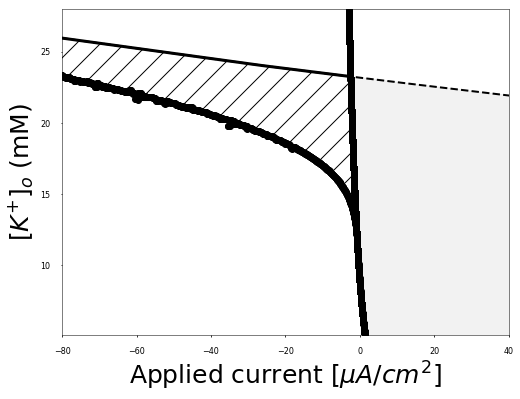

In [11]:
from scipy.interpolate import interp1d
size_axis_font=25
plt.close("all")

fig01 = plt.figure(facecolor="1",figsize=(8,6))
axx = fig01.add_subplot(111)
xlim=[-80,40]
ylim=[5.1,28]
axx.set_xlim(xlim)
axx.set_ylim(ylim)

s_x=1;s_y=0
##### plot sn disappearance, hopf and limit cycle onset
axx.plot(m_res_par_sn_KoIapp[s_x],m_res_par_sn_KoIapp[s_y],'o',color=[0,0,0])
axx.plot(m_res_par_lc_KoIapp[s_x],m_res_par_lc_KoIapp[s_y],'o',color=[0,0,0])
axx.plot(m_res_par_HF0[s_x],m_res_par_HF0[s_y],'--',linewidth=2,color=[0,0,0])

##### Drawing the different regions
a=m_res_par_lc_KoIapp[s_x]
b=m_res_par_sn_KoIapp[s_y]
bx=m_res_par_sn_KoIapp[s_x]
c=m_res_par_HF0[s_x]
cy=m_res_par_HF0[s_y]
f1x = interp1d(m_res_par_sn_KoIapp[s_y][bx.argsort()],bx[bx.argsort()],fill_value=min(m_res_par_sn_KoIapp[s_x]), bounds_error=False)
f2x = interp1d(m_res_par_lc_KoIapp[s_y][a.argsort()],a[a.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
f3x = interp1d(m_res_par_HF0[s_y][c.argsort()],c[c.argsort()],fill_value=min(m_res_par_lc_KoIapp[s_x]), bounds_error=False)
yy=m_res_par_sn_KoIapp[s_x][b.argsort()]
yy2=np.minimum(f3x(b[b.argsort()]),yy)

##### filling the different regions
axx.fill_betweenx(b[b.argsort()],f2x(b[b.argsort()]),yy2,facecolor="none",hatch="/",lw=3., edgecolor='k')
cc=[i for i in b.argsort() if f3x(b[i])>f1x(b[i])]
axx.fill_betweenx(b[cc],f1x(b[cc]),f3x(b[cc]),color='k',alpha=.05)

##### Plot axes
axx.set_ylabel('$[K^{+}]_o $ (mM)',fontsize=size_axis_font)
axx.set_xlabel('Applied current $[\mu A/cm^2]$',fontsize=size_axis_font)
axx.tick_params(axis='y', pad=10)
axx.tick_params(axis='x', pad=10)
plt.show()




# Mixing factor

In [12]:
#### Check potentials
from sympy import S, symbols, lambdify
from sympy.parsing.sympy_parser import parse_expr
from scipy.special import erf



v_len_isifp_Traub=[]
v_len_isilc_Traub=[]
v_len_isifp_Traub_inperfct=[]
v_len_isi_Traub=[]
v_len_4_line_int=[]

v_dlc=[]
v_ynys0=[]
v_lam0=[]
v_lamfp=[]
v_taulc=[]
v_D=[]
v_omega_Traub=[]
v_omega_numeric=[]
v_omega_approx=[]
### Noise intensity
v_siigma=[]
sii=0.5#\muA



v_Koi=[]
v_DU_ovD=[]
v_DUdlc_ovD=[]
v_DUdlc=[]

for K_o in [12.5,12.75,13.0,13.25,13.5]:
    I_app=-10
    ### Finding bistable region boundaries for particular Ko
    lb=m_res_par_lc_KoIapp[s_x][np.argmin(np.abs(m_res_par_lc_KoIapp[s_y]-K_o))]
    ub=m_res_par_sn_KoIapp[s_x][np.argmin(np.abs(m_res_par_sn_KoIapp[s_y]-K_o))]

    ## Applied currents in the subthreshold, bistable, and spiking regions.
    if (ub-lb)/5>1*10**-3:
#         t_I_app_specf=[lb+(ub-lb)/5,lb+2*(ub-lb)/5,lb+3*(ub-lb)/5,lb+4*(ub-lb)/5]
        t_I_app_specf=[lb+(ub-lb)/10,lb+2*(ub-lb)/10,lb+3*(ub-lb)/10,lb+4*(ub-lb)/10,lb+5*(ub-lb)/10,lb+6*(ub-lb)/10,lb+7*(ub-lb)/10,lb+8*(ub-lb)/10,lb+9*(ub-lb)/10]
    else:
        t_I_app_specf=[lb+(ub-lb)/2]
        
        
    ### Noise only in the voltage dimension
    sigma_v=[sii,0,0,0]
    ## To load simulation
    num_neurons=500
    for ii_iapi in range(len(t_I_app_specf)):
        I_app=t_I_app_specf[ii_iapi]
        bifpar={}
        bifpar[strIapp] = [str(t_I_app_specf[ii_iapi])+"* uA/cm2"]
        bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
        name='SIM_'+model_name+'_I_app_'+bifpar['I_app'][0][0:bifpar['I_app'][0].index('*')]+'_K_o_'+bifpar['K_o'][0][1:bifpar['K_o'][0].index('*')]+'_sigma_'+str(sigma_v[0])
        
        if os.path.isfile('./Data/'+name+'.pkl'):
            print(name+' exists!')
            f=open('./Data/'+name+'.pkl', 'rb')
            d_save_sim=pickle.load(f)
            f.close()
            ####################### Extract attractor properties
            l0=d_save_sim['Dyn_Sys_Properties']['l0']
            limit_cycle=d_save_sim['Dyn_Sys_Properties']['limit_cycle']
            tau_lc=d_save_sim['Dyn_Sys_Properties']['tau_lc']
            saddle=d_save_sim['Dyn_Sys_Properties']['saddle']
            node=d_save_sim['Dyn_Sys_Properties']['stable']
            lam0=d_save_sim['Dyn_Sys_Properties']['lam0']
            lamfp=d_save_sim['Dyn_Sys_Properties']['lamfp']
            if len(d_save_sim['Dyn_Sys_Properties']['limit_cycle'])>0:
                ### Distances in l0
                dlc=min(np.dot(l0,limit_cycle-saddle))
                yn=np.dot(l0,node)
                ys_0=np.dot(l0,saddle)
                sig_eff=np.dot(sigma_v,l0)
                D=sig_eff**2
                
                
                #### Loading ISIs of trajectories that go through the fp.
                if len(d_save_sim['Mult_spike_reals']['ISI_fp'])>0:
                    ISI_fp_Traub=np.concatenate(d_save_sim['Mult_spike_reals']['ISI_fp'])
                    ISI_lc_Traub=np.concatenate(d_save_sim['Mult_spike_reals']['ISI_lc'])
                    ISI_fp_Traub_inperfct=np.concatenate(d_save_sim['Mult_spike_reals']['v_ISI_fp_inperfct'])
                    
                else:
                    ISI_fp_Traub=[]


                if len(ISI_fp_Traub)>2:
                    v_ISI=[]
                    for ii,ii_spikes in enumerate(np.concatenate(d_save_sim['Mult_spike_reals']['spikes'])):
                        v_isi=ii_spikes[1:]-ii_spikes[:-1]
                        v_ISI.append(v_isi)
                    
                    v_ISI=np.concatenate(v_ISI)
                    omega_Traub=len(ISI_fp_Traub)/len(v_ISI)
                                        
                    v_len_isi_Traub.append(len(v_ISI))
                    v_len_isifp_Traub.append(len(ISI_fp_Traub))
                    v_len_isilc_Traub.append(len(ISI_lc_Traub))
                    v_len_isifp_Traub_inperfct.append(len(ISI_fp_Traub_inperfct))
                    
                    v_dlc.append(dlc)
                    v_ynys0.append(yn-ys_0)
                    v_lam0.append(lam0)
                    v_lamfp.append(lamfp)
                    v_taulc.append(tau_lc)
                    v_D.append(D)
                    v_omega_Traub.append(omega_Traub)
                    ## Storing d_fp
                    v_ynys0.append(yn-ys_0)
                    v_siigma.append(sii)
                    v_Koi.append(K_o)
                    ##############################################################################################################
                    ########## mixing factor from line integral
                    ##############################################################################################################
                    ### Loading the line integral in l0 that was calculated in (p_traub_to_GIF_potentials.py)
                    dir_sims='./Data/'
                    name='d_sample_of_det_potentials_'+model_name
                    f=open(dir_sims+name+'.pkl', 'rb')
                    d_POTs=pickle.load(f)
                    f.close()
                    ############################################################
                    ### Finding the potential for this particular Iapp and Uy
                    ############################################################
                    v_Iappi_pots=[]
                    v_Ko_pots=[]
                    for d_pot_i in d_POTs:
                        v_Ko_pots.append(d_pot_i['K_o'])
                        v_Iappi_pots.append(d_pot_i['I_app'])

                    pot_idx=np.array(range(len(v_Iappi_pots)))[v_Iappi_pots==I_app]
                    if len(pot_idx)==1 and v_Ko_pots[pot_idx[0]]==K_o:
                        pot_idx=pot_idx[0]
                    elif len(pot_idx)>1:
                        for ii_poti_idx in pot_idx:
                            if v_Ko_pots[pii_poti_idx]==K_o:
                                pot_idx=ii_poti_idx

                    yy_tot_t=d_POTs[pot_idx]['Dyn_Sys_Properties']['Det_Uy_in_l0']['yy_tot_t']
                    Uy_tot_t=d_POTs[pot_idx]['Dyn_Sys_Properties']['Det_Uy_in_l0']['Uy_tot_t']
                    ### shifting Uy such that U(0)=0
                    Uy_tot_t=Uy_tot_t-Uy_tot_t[np.argmin(abs(yy_tot_t))]
                    ############################################################
                    ### Decreasing resolution, to optimize running time
                    ############################################################
                    delta=0.001
                    idxs_Vy_shrt=[]
                    idxs_Vy_shrt.append(np.array(range(len(yy_tot_t)))[1:][np.diff(yy_tot_t)>delta])
                    idxs_Vy_shrt.append(np.array(range(len(yy_tot_t)))[1:][(np.diff(yy_tot_t)<delta)*(np.diff(yy_tot_t)>0)][::5])
                    idxs_Vy_shrt=np.sort(np.concatenate(idxs_Vy_shrt))
                    Uy_temp=Uy_tot_t[idxs_Vy_shrt]
                    yy_temp=yy_tot_t[idxs_Vy_shrt]
                    v_len_4_line_int.append(len(np.array(range(len(yy_temp)))[(yy_temp>=yn[0]-ys_0[0])*(yy_temp<=float('%.4g' % dlc))]))
                    print(len(np.array(range(len(yy_temp)))[(yy_temp>=yn[0]-ys_0[0])*(yy_temp<=float('%.4g' % dlc))]))
                    ####################### 
                    ###### Mixing factor
                    #9.1.10 Gardiner.. (numerica solution).. assuming, initial condition sqrt(D) away from dl
                    def phi_a(y_a,y_b,y_c):
                        ### First limits of integration
                        idxs_Vy=np.array(range(len(yy_temp)))[(yy_temp>=y_b)*(yy_temp<=y_c)]
                        v_y=yy_temp[idxs_Vy]
                        inti_nom=np.trapz(np.exp(Uy_temp[idxs_Vy]/D),x=v_y)
                        ### Second limits of integration
                        idxs_Vy=np.array(range(len(yy_temp)))[(yy_temp>=y_a)*(yy_temp<=y_c)]
                        v_y=yy_temp[idxs_Vy]
                        inti_denom=np.trapz(np.exp(Uy_temp[idxs_Vy]/D),x=v_y)
                        return inti_nom/inti_denom


                    ### instead of upper integration boundary of equation 39 to be inf, is set to 5.0>>d_lc
                    omega_numeric=phi_a(yn[0]-ys_0[0],float('%.4g' % dlc),5.0)
                    v_omega_numeric.append(omega_numeric)
                    ####################### 
                    ###### Mixing factor
                    #9.1.21 Gardiner.. (Solution for infinitesimally distant from b)
                    omega_aprox=(1/2)*(1-erf(dlc*np.sqrt(abs(lam0)/(D))))
                    v_omega_approx.append(omega_aprox)
                        
                    v_DU_ovD.append((-Uy_tot_t[np.argmin(abs(yy_tot_t-(yn-ys_0)))]+Uy_tot_t[np.argmin(abs(yy_tot_t))])/D)
                    v_DUdlc_ovD.append((-Uy_tot_t[np.argmin(abs(yy_tot_t-(float('%.4g' % dlc))))]+Uy_tot_t[np.argmin(abs(yy_tot_t))])/D)
                    v_DUdlc.append(-Uy_tot_t[np.argmin(abs(yy_tot_t-(float('%.4g' % dlc))))]+Uy_tot_t[np.argmin(abs(yy_tot_t))])

                else:
                    print('not enough fp visits..')
                
            else:
                print('no limit cycle :(...')



            


SIM_MTM_W_sPNaS_snapshot_p0_I_app_-0.960852858332_K_o_12.5_sigma_0.5 exists!
8232
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-0.949213190774_K_o_12.5_sigma_0.5 exists!
9204
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-0.937573523216_K_o_12.5_sigma_0.5 exists!
10821
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-0.925933855658_K_o_12.5_sigma_0.5 exists!
11933
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.076300466075_K_o_12.75_sigma_0.5 exists!
no limit cycle :(...
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.06392985175_K_o_12.75_sigma_0.5 exists!
7282
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.051559237425_K_o_12.75_sigma_0.5 exists!
not enough fp visits..
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.0391886231_K_o_12.75_sigma_0.5 exists!
7530
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.0268180087749998_K_o_12.75_sigma_0.5 exists!
not enough fp visits..
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.0144473944499999_K_o_12.75_sigma_0.5 exists!
8300
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.002076780125_K_o_12.75_sigma_0.5 exists!
not enough fp visits..
SIM_MTM_W_sPNa

In [13]:
ii_num_thres=50000

### more than ii_num_thres visits to fp and to lc in both models..
a_tb=(np.array(v_len_isifp_Traub)>ii_num_thres)
b_tb=(np.array(v_len_isilc_Traub)>ii_num_thres)

b_inti_b=(np.array(v_len_4_line_int)>6000)
acpt_thres=np.array(range(len(v_len_isifp_Traub)))[a_tb*b_tb*b_inti_b]


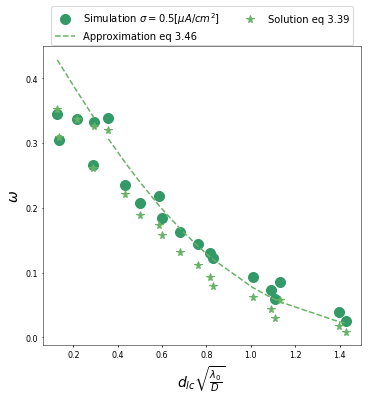

<Figure size 410.4x360 with 0 Axes>

In [23]:

f11 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*1.1))
ax = plt.subplot2grid((1,1), (0, 0),colspan=1,rowspan=1)

######
jet= plt.get_cmap('summer')
colors = iter(jet(np.linspace(0.2,0.8,4)))
colorii=next(colors)

z=np.array(v_siigma)[acpt_thres]
### First plot one sigma
idx_sigma0=np.array(range(len(z)))[z==0.5]
x=np.sqrt(np.abs(v_lam0)/(np.array(v_D)))*np.abs(v_dlc)
x=x[acpt_thres][idx_sigma0]



y=np.array(v_omega_Traub)[acpt_thres]
y=y[idx_sigma0]

nonempty=[type(yi)!=list for yi in y]
x=x[nonempty]
y=y[nonempty]

if len(z[idx_sigma0])>0:
    ax.plot(x,y,'o',markersize=10,label=r'Simulation $\sigma=$'+str(z[idx_sigma0][0])+'$[\mu A/cm^2]$',color=colorii)

if len(x)>0:

    colorii=next(colors)
    y=np.array(v_omega_approx)[acpt_thres][idx_sigma0]
    nonempty=[type(yi)!=list for yi in y]
    x=x[nonempty]
    y=y[nonempty]
    x=x[y<0.32]
    y=y[y<0.32]
    iis=np.argsort(x)
    ax.plot(x[iis],y[iis],'--',label='Approximation eq 3.46',color=colorii)
    
    y=np.array(v_omega_approx)[acpt_thres][idx_sigma0]
    nonempty=[type(yi)!=list for yi in y]
    x=np.sqrt(np.abs(v_lam0)/(np.array(v_D)))*np.abs(v_dlc)
    x=x[acpt_thres][idx_sigma0]

    x=x[nonempty]
    y=y[nonempty]
    x=x[y>0.32]
    y=y[y>0.32]
    iis=np.argsort(x)
    ax.plot(x[iis],y[iis],'--',color=colorii)
    
    y=np.array(v_omega_numeric)[acpt_thres][idx_sigma0]
    nonempty=[type(yi)!=list for yi in y]
    x=np.sqrt(np.abs(v_lam0)/(np.array(v_D)))*np.abs(v_dlc)
    x=x[acpt_thres][idx_sigma0]
    
    x=x[nonempty]
    y=y[nonempty]
    x=x[y<0.32]
    y=y[y<0.32]
    iis=np.argsort(x)
    ax.plot(x[iis],y[iis],'*',markersize=8,label='Solution eq 3.39',color=colorii)
    
    y=np.array(v_omega_numeric)[acpt_thres][idx_sigma0]
    nonempty=[type(yi)!=list for yi in y]
    x=np.sqrt(np.abs(v_lam0)/(np.array(v_D)))*np.abs(v_dlc)
    x=x[acpt_thres][idx_sigma0]

    x=x[nonempty]
    y=y[nonempty]
    x=x[y>0.32]
    y=y[y>0.32]
    iis=np.argsort(x)
    ax.plot(x[iis],y[iis],'*',markersize=8,color=colorii)

 

ax.set_ylabel(r'$ \omega$',fontsize=14)
ax.set_xlabel(r'$d_{lc}\sqrt{\frac{\lambda_{0}}{D}}$',fontsize=14)
ax.legend(loc='upper center', fontsize=10,bbox_to_anchor=(0.5, 1.15),
          ncol=2, fancybox=True, )

fig_name='omega_vs_dlcsqrtlamdad_simulations_'+model_name+'_sigmav_'+str(z[idx_sigma0][0])

md_dir={}
md_dir['Title']='omega vs dlc sqrt(lamda/D) simulations vs theory eqs. 5.2.164-5.2.166 Gardiner'+model_name+' for sigmav='+str(sigma_v)+'mult Iapps inside bistable region and K_o='+''.join(['_'+str([12.5,12.75,13.0,13.25,13.5])])
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

saving_pdf_figure(f11,'./figs/'+fig_name,md_dir,raster=300)
# plt.show()

In [24]:
md_dir

{'Title': 'omega vs dlc sqrt(lamda/D) simulations vs theory eqs. 5.2.164-5.2.166 GardinerMTM_W_sPNaS_snapshot_p0 for sigmav=[0.2, 0, 0, 0]mult Iapps inside bistable region and K_o=_[12.5, 12.75, 13.0, 13.25, 13.5]',
 'Author': 'Susana Contreras',
 'Subject': 'stochastic bursting',
 'Keywords': 'Bistability, concentration dynamics, spiking statistics'}

In [15]:
#### Check potentials
from sympy import S, symbols, lambdify
from sympy.parsing.sympy_parser import parse_expr
from scipy.special import erf

### Loading simulations with different noise intentisities
sii=0.2#\muA


for K_o in [12.5,12.75,13.0,13.25,13.5]:
    I_app=-10
    ### Finding bistable region boundaries for particular Ko
    lb=m_res_par_lc_KoIapp[s_x][np.argmin(np.abs(m_res_par_lc_KoIapp[s_y]-K_o))]
    ub=m_res_par_sn_KoIapp[s_x][np.argmin(np.abs(m_res_par_sn_KoIapp[s_y]-K_o))]

    ## Applied currents in the subthreshold, bistable, and spiking regions.
    if (ub-lb)/5>1*10**-3:
#         t_I_app_specf=[lb+(ub-lb)/5,lb+2*(ub-lb)/5,lb+3*(ub-lb)/5,lb+4*(ub-lb)/5]
        t_I_app_specf=[lb+(ub-lb)/10,lb+2*(ub-lb)/10,lb+3*(ub-lb)/10,lb+4*(ub-lb)/10,lb+5*(ub-lb)/10,lb+6*(ub-lb)/10,lb+7*(ub-lb)/10,lb+8*(ub-lb)/10,lb+9*(ub-lb)/10]
    else:
        t_I_app_specf=[lb+(ub-lb)/2]
        
        
    ### Noise only in the voltage dimension
    sigma_v=[sii,0,0,0]
    ## To load simulation
    num_neurons=500
    for ii_iapi in range(len(t_I_app_specf)):
        I_app=t_I_app_specf[ii_iapi]
        bifpar={}
        bifpar[strIapp] = [str(t_I_app_specf[ii_iapi])+"* uA/cm2"]
        bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
        name='SIM_'+model_name+'_I_app_'+bifpar['I_app'][0][0:bifpar['I_app'][0].index('*')]+'_K_o_'+bifpar['K_o'][0][1:bifpar['K_o'][0].index('*')]+'_sigma_'+str(sigma_v[0])
        
        if os.path.isfile('./Data/'+name+'.pkl'):
            print(name+' exists!')
            f=open('./Data/'+name+'.pkl', 'rb')
            d_save_sim=pickle.load(f)
            f.close()
            ####################### Extract attractor properties
            l0=d_save_sim['Dyn_Sys_Properties']['l0']
            limit_cycle=d_save_sim['Dyn_Sys_Properties']['limit_cycle']
            tau_lc=d_save_sim['Dyn_Sys_Properties']['tau_lc']
            saddle=d_save_sim['Dyn_Sys_Properties']['saddle']
            node=d_save_sim['Dyn_Sys_Properties']['stable']
            lam0=d_save_sim['Dyn_Sys_Properties']['lam0']
            lamfp=d_save_sim['Dyn_Sys_Properties']['lamfp']
            if len(d_save_sim['Dyn_Sys_Properties']['limit_cycle'])>0:
                ### Distances in l0
                dlc=min(np.dot(l0,limit_cycle-saddle))
                yn=np.dot(l0,node)
                ys_0=np.dot(l0,saddle)
                sig_eff=np.dot(sigma_v,l0)
                D=sig_eff**2
                
                
                #### Loading ISIs of trajectories that go through the fp.
                if len(d_save_sim['Mult_spike_reals']['ISI_fp'])>0:
                    ISI_fp_Traub=np.concatenate(d_save_sim['Mult_spike_reals']['ISI_fp'])
                    ISI_lc_Traub=np.concatenate(d_save_sim['Mult_spike_reals']['ISI_lc'])
                    ISI_fp_Traub_inperfct=np.concatenate(d_save_sim['Mult_spike_reals']['v_ISI_fp_inperfct'])
                    
                else:
                    ISI_fp_Traub=[]


                if len(ISI_fp_Traub)>2:
                    v_ISI=[]
                    for ii,ii_spikes in enumerate(np.concatenate(d_save_sim['Mult_spike_reals']['spikes'])):
                        v_isi=ii_spikes[1:]-ii_spikes[:-1]
                        v_ISI.append(v_isi)
                    
                    v_ISI=np.concatenate(v_ISI)
                    omega_Traub=len(ISI_fp_Traub)/len(v_ISI)
                                        
                    v_len_isi_Traub.append(len(v_ISI))
                    v_len_isifp_Traub.append(len(ISI_fp_Traub))
                    v_len_isilc_Traub.append(len(ISI_lc_Traub))
                    v_len_isifp_Traub_inperfct.append(len(ISI_fp_Traub_inperfct))
                    
                    v_dlc.append(dlc)
                    v_ynys0.append(yn-ys_0)
                    v_lam0.append(lam0)
                    v_lamfp.append(lamfp)
                    v_taulc.append(tau_lc)
                    v_D.append(D)
                    v_omega_Traub.append(omega_Traub)
                    ## Storing d_fp
                    v_ynys0.append(yn-ys_0)
                    v_siigma.append(sii)
                    v_Koi.append(K_o)
                    ##############################################################################################################
                    ########## mixing factor from line integral
                    ##############################################################################################################
                    ### Loading the line integral in l0 that was calculated in (p_traub_to_GIF_potentials.py)
                    dir_sims='./Data/'
                    name='d_sample_of_det_potentials_'+model_name
                    f=open(dir_sims+name+'.pkl', 'rb')
                    d_POTs=pickle.load(f)
                    f.close()
                    ############################################################
                    ### Finding the potential for this particular Iapp and Uy
                    ############################################################
                    v_Iappi_pots=[]
                    v_Ko_pots=[]
                    for d_pot_i in d_POTs:
                        v_Ko_pots.append(d_pot_i['K_o'])
                        v_Iappi_pots.append(d_pot_i['I_app'])

                    pot_idx=np.array(range(len(v_Iappi_pots)))[v_Iappi_pots==I_app]
                    if len(pot_idx)==1 and v_Ko_pots[pot_idx[0]]==K_o:
                        pot_idx=pot_idx[0]
                    elif len(pot_idx)>1:
                        for ii_poti_idx in pot_idx:
                            if v_Ko_pots[pii_poti_idx]==K_o:
                                pot_idx=ii_poti_idx

                    yy_tot_t=d_POTs[pot_idx]['Dyn_Sys_Properties']['Det_Uy_in_l0']['yy_tot_t']
                    Uy_tot_t=d_POTs[pot_idx]['Dyn_Sys_Properties']['Det_Uy_in_l0']['Uy_tot_t']
                    ### shifting Uy such that U(0)=0
                    Uy_tot_t=Uy_tot_t-Uy_tot_t[np.argmin(abs(yy_tot_t))]
                    ############################################################
                    ### Decreasing resolution, to optimize running time
                    ############################################################
                    delta=0.001
                    idxs_Vy_shrt=[]
                    idxs_Vy_shrt.append(np.array(range(len(yy_tot_t)))[1:][np.diff(yy_tot_t)>delta])
                    idxs_Vy_shrt.append(np.array(range(len(yy_tot_t)))[1:][(np.diff(yy_tot_t)<delta)*(np.diff(yy_tot_t)>0)][::5])
                    idxs_Vy_shrt=np.sort(np.concatenate(idxs_Vy_shrt))
                    Uy_temp=Uy_tot_t[idxs_Vy_shrt]
                    yy_temp=yy_tot_t[idxs_Vy_shrt]
                    v_len_4_line_int.append(len(np.array(range(len(yy_temp)))[(yy_temp>=yn[0]-ys_0[0])*(yy_temp<=float('%.4g' % dlc))]))
                    print(len(np.array(range(len(yy_temp)))[(yy_temp>=yn[0]-ys_0[0])*(yy_temp<=float('%.4g' % dlc))]))
                    ####################### 
                    ###### Mixing factor
                    #9.1.10 Gardiner.. (numerica solution).. assuming, initial condition sqrt(D) away from dl
                    def phi_a(y_a,y_b,y_c):
                        ### First limits of integration
                        idxs_Vy=np.array(range(len(yy_temp)))[(yy_temp>=y_b)*(yy_temp<=y_c)]
                        v_y=yy_temp[idxs_Vy]
                        inti_nom=np.trapz(np.exp(Uy_temp[idxs_Vy]/D),x=v_y)
                        ### Second limits of integration
                        idxs_Vy=np.array(range(len(yy_temp)))[(yy_temp>=y_a)*(yy_temp<=y_c)]
                        v_y=yy_temp[idxs_Vy]
                        inti_denom=np.trapz(np.exp(Uy_temp[idxs_Vy]/D),x=v_y)
                        return inti_nom/inti_denom


                    ### instead of upper integration boundary of equation 39 to be inf, is set to 5.0>>d_lc
                    omega_numeric=phi_a(yn[0]-ys_0[0],float('%.4g' % dlc),5.0)
                    v_omega_numeric.append(omega_numeric)
                    ####################### 
                    ###### Mixing factor
                    #9.1.21 Gardiner.. (Solution for infinitesimally distant from b)
                    omega_aprox=(1/2)*(1-erf(dlc*np.sqrt(abs(lam0)/(D))))
                    v_omega_approx.append(omega_aprox)
                        
                    v_DU_ovD.append((-Uy_tot_t[np.argmin(abs(yy_tot_t-(yn-ys_0)))]+Uy_tot_t[np.argmin(abs(yy_tot_t))])/D)
                    v_DUdlc_ovD.append((-Uy_tot_t[np.argmin(abs(yy_tot_t-(float('%.4g' % dlc))))]+Uy_tot_t[np.argmin(abs(yy_tot_t))])/D)
                    v_DUdlc.append(-Uy_tot_t[np.argmin(abs(yy_tot_t-(float('%.4g' % dlc))))]+Uy_tot_t[np.argmin(abs(yy_tot_t))])

                else:
                    print('not enough fp visits..')
                
            else:
                print('no limit cycle :(...')



            


SIM_MTM_W_sPNaS_snapshot_p0_I_app_-0.960852858332_K_o_12.5_sigma_0.2 exists!
8232
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-0.949213190774_K_o_12.5_sigma_0.2 exists!
9204
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-0.937573523216_K_o_12.5_sigma_0.2 exists!
10821
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-0.925933855658_K_o_12.5_sigma_0.2 exists!
11933
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.076300466075_K_o_12.75_sigma_0.2 exists!
no limit cycle :(...
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.06392985175_K_o_12.75_sigma_0.2 exists!
6128
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.051559237425_K_o_12.75_sigma_0.2 exists!
not enough fp visits..
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.0391886231_K_o_12.75_sigma_0.2 exists!
7190
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.0268180087749998_K_o_12.75_sigma_0.2 exists!
not enough fp visits..
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.0144473944499999_K_o_12.75_sigma_0.2 exists!
8106
SIM_MTM_W_sPNaS_snapshot_p0_I_app_-1.002076780125_K_o_12.75_sigma_0.2 exists!
not enough fp visits..
SIM_MTM_W_sPNa

In [16]:
ii_num_thres=50000

### more than ii_num_thres visits to fp and to lc in both models..
a_tb=(np.array(v_len_isifp_Traub)>ii_num_thres)
b_tb=(np.array(v_len_isilc_Traub)>ii_num_thres)

b_inti_b=(np.array(v_len_4_line_int)>6000)
acpt_thres=np.array(range(len(v_len_isifp_Traub)))[a_tb*b_tb*b_inti_b]


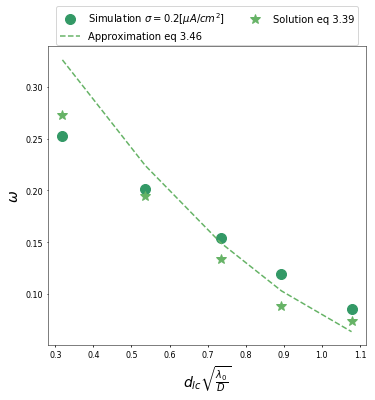

In [20]:

f11 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*1.1))
ax = plt.subplot2grid((1,1), (0, 0),colspan=1,rowspan=1)

######



jet= plt.get_cmap('summer')
colors = iter(jet(np.linspace(0.2,0.8,4)))
colorii=next(colors)


z=np.array(v_siigma)[acpt_thres]
### First plot one sigma
idx_sigma0=np.array(range(len(z)))[z==0.2]

x=np.sqrt(np.abs(v_lam0)/(np.array(v_D)))*np.abs(v_dlc)
x=x[acpt_thres][idx_sigma0]
iis=np.argsort(x)

# y=np.array(v_omega_Traub_pure)[acpt_thres]
y=np.array(v_omega_Traub)[acpt_thres]
y=y[idx_sigma0]

nonempty=[type(yi)!=list for yi in y]
x=x[nonempty]
y=y[nonempty]

if len(z[idx_sigma0])>0:
    ax.plot(x,y,'o',markersize=10,label=r'Simulation $\sigma=$'+str(z[idx_sigma0][0])+'$[\mu A/cm^2]$',color=colorii)

if len(x)>0:
    #### Comparison to theory
    colorii=next(colors)
    y=np.array(v_omega_approx)[acpt_thres][idx_sigma0][iis]
    nonempty=[type(yi)!=list for yi in y]
    x=x[nonempty]
    y=y[nonempty]
    ax.plot(x,y,'--',label='Approximation eq 3.46',color=colorii)

    y=np.array(v_omega_numeric)[acpt_thres][idx_sigma0][iis]
    nonempty=[type(yi)!=list for yi in y]
    x=x[nonempty]
    y=y[nonempty]
    ax.plot(x,y,'*',markersize=10,label='Solution eq 3.39',color=colorii)

 

ax.set_ylabel(r'$ \omega$',fontsize=14)
ax.set_xlabel(r'$d_{lc}\sqrt{\frac{\lambda_{0}}{D}}$',fontsize=14)
ax.legend(loc='upper center', fontsize=10,bbox_to_anchor=(0.5, 1.15),
          ncol=2, fancybox=True)




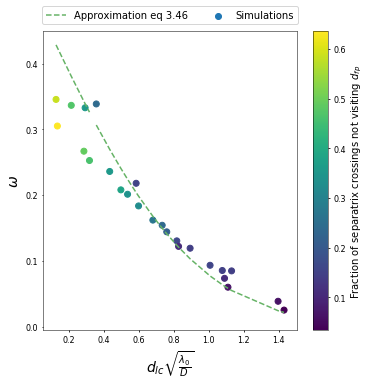

<Figure size 410.4x360 with 0 Axes>

In [21]:

f11 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*1.1))
ax = plt.subplot2grid((1,1), (0, 0),colspan=1,rowspan=1)

######
jet= plt.get_cmap('summer')
colors = iter(jet(np.linspace(0.2,0.8,4)))
colorii=next(colors)


z=np.array(v_siigma)[acpt_thres]
### Plot all sigmas..
idx_sigma0=np.array(range(len(z)))

x=np.sqrt(np.abs(v_lam0)/(np.array(v_D)))*np.abs(v_dlc)
x=x[acpt_thres][idx_sigma0]

y=np.array(v_omega_Traub)[acpt_thres]
y=y[idx_sigma0]

zz=np.array(v_len_isifp_Traub_inperfct)/np.array(v_len_isi_Traub)
zz=zz[acpt_thres][idx_sigma0]

nonempty=[type(yi)!=list for yi in y]
x=x[nonempty]
y=y[nonempty]
zz=zz[nonempty]

if len(z[idx_sigma0])>0:
    sc=ax.scatter(x,y,label=r'Simulations',c=zz)

if len(x)>0:
    colorii=next(colors)
    y=np.array(v_omega_approx)[acpt_thres][idx_sigma0]
    nonempty=[type(yi)!=list for yi in y]
    x=x[nonempty]
    y=y[nonempty]
    x=x[y<0.32]
    y=y[y<0.32]
    iis=np.argsort(x)
    ax.plot(x[iis],y[iis],'--',label='Approximation eq 3.46',color=colorii)
    
    y=np.array(v_omega_approx)[acpt_thres][idx_sigma0]
    nonempty=[type(yi)!=list for yi in y]
    x=np.sqrt(np.abs(v_lam0)/(np.array(v_D)))*np.abs(v_dlc)
    x=x[acpt_thres][idx_sigma0]

    x=x[nonempty]
    y=y[nonempty]
    x=x[y>0.32]
    y=y[y>0.32]
    iis=np.argsort(x)
    ax.plot(x[iis],y[iis],'--',color=colorii)

    y=np.array(v_omega_numeric)[acpt_thres][idx_sigma0]
    nonempty=[type(yi)!=list for yi in y]
    x=np.sqrt(np.abs(v_lam0)/(np.array(v_D)))*np.abs(v_dlc)
    x=x[acpt_thres][idx_sigma0]



z=np.array(v_siigma)[acpt_thres]
### First plot one sigma
idx_sigma0=np.array(range(len(z)))[z==0.5]

x=np.sqrt(np.abs(v_lam0)/(np.array(v_D)))*np.abs(v_dlc)
x=x[acpt_thres][idx_sigma0]

cbar=plt.colorbar(sc)
cbar.set_label('Fraction of separatrix crossings not visiting $d_{fp}$') 

 

ax.set_ylabel(r'$ \omega$',fontsize=14)
ax.set_xlabel(r'$d_{lc}\sqrt{\frac{\lambda_{0}}{D}}$',fontsize=14)
ax.legend(loc='upper center', fontsize=10,bbox_to_anchor=(0.5, 1.1),
          ncol=2, fancybox=True, )

fig_name='w_vs_dlcsqrtlamdad_simulations_wrd_trajs_'+model_name+'_sigmav_'+str(z[idx_sigma0][0])

md_dir={}
md_dir['Title']='omega vs dlc sqrt(lamda/D) simulations vs theory where approx fails eqs. 5.2.164-5.2.166 Gardiner'+model_name+' for sigmav='+str(sigma_v)+'mult Iapps inside bistable region and K_o='+''.join(['_'+str([12.5,12.75,13.0,13.25,13.5])])
md_dir['Author']= 'Susana Contreras'
md_dir['Subject']='stochastic bursting'
md_dir['Keywords']='Bistability, concentration dynamics, spiking statistics'

saving_pdf_figure(f11,'./figs/'+fig_name,md_dir,raster=300)
# plt.show()

In [22]:
md_dir

{'Title': 'omega vs dlc sqrt(lamda/D) simulations vs theory where approx fails eqs. 5.2.164-5.2.166 GardinerMTM_W_sPNaS_snapshot_p0 for sigmav=[0.2, 0, 0, 0]mult Iapps inside bistable region and K_o=_[12.5, 12.75, 13.0, 13.25, 13.5]',
 'Author': 'Susana Contreras',
 'Subject': 'stochastic bursting',
 'Keywords': 'Bistability, concentration dynamics, spiking statistics'}